# Customer Segmentation with KMeans Clustering

## Problem statement

In this notebook, we will take a look at a UK-based retail store and their transactions over a **1 year period** from December 2010 to December 2011.
The purpose of this analysis is to find **distinct** clusters among the clients, based on the given data and inspect the behaviour of customers unqiue to each cluster.

How much *business value* does a given customer carry for the retail store? Let's dive right in and answer this question.

# <u>Contents:</u>

## <a href="#sec 1"> Section 1: Exploratory Data Analysis</a>
 <ol type="a">
  <li><a href="#1.1"> Understanding the Dataset</a></li>
  <li><a href="#1.2">  Item and Time analysis</a></li>
  <li><a href="#1.3">Return transactions & Missing Data</a></li>  
</ol>

## <a href="#sec 2"> Section 2: Feature Engineering</a>
 <ol type="a">
  <li><a href="#2.1"> Recency</a></li>
  <li><a href="#2.2"> Frequency</a></li>
  <li><a href="#2.3"> Monetary Value</a></li>
  <li><a href="#2.4"> Data preprocessing</a></li>
</ol>


## <a href="#sec 3"> Section 3: K-Means Clustering  </a>
 <ol type="a">
  <li><a href="#3.1">Finding three prime clusters</a></li>
  <li><a href="#3.2">Analyzing the clusters</a></li>   
</ol>
  
## <a href="#sec 4"> Section 4: Conclusion  </a>
 <ol type="a">
  <li><a href="#4.1">Evaluating the results</a></li>
  <li><a href="#4.2">Future considerations</a></li>   
</ol>

# <div id="sec 1">Section 1: Exploratory Data Analysis</div>

## <div id="1.1">1.1:  Understanding the Dataset</div>

As always, before we can do anything else, we must import the dataset **and** some crucial libraries.

In [221]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats 
import matplotlib as mpl
from numpy import nan
import seaborn as sn
import datetime
import math
import matplotlib.mlab as mlab

import warnings
warnings.filterwarnings('ignore')

Using pandas, we can read in our dataset.

In [222]:
df = pd.read_excel(io=r'Online Retail.xlsx')

#Make a copy
df_copy = df.copy()

In [223]:
df.shape

(541909, 8)

It looks like we have **over half a million** rows of transactional data. Let's peek into the first few rows.

In [224]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Let's discuss each of the features briefly. **InvoiceNo** refers to the ID of a particular transaction and is complemented by the associated **InvoiceDate**.

**Description** tells us the item included in the transaction and **StockCode** is the ID number of the object.

**Quantity** and **UnitPrice** are rather self-explanatory, whereas **Country** refers to the customer's location. Let's note that we can obtain an important variable as a combination of two others, defined as:

$$Amount = Quantity * UnitPrice $$

**CustomerID** refers to a given individual who has done some business with the retail store.



In [225]:
df['Amount'] = df['Quantity'] * df['UnitPrice']

### Country

In [226]:
len(df.Country.unique())

38

Let's investigate the spread of transactions across the top 10 (out of the **38**) countries.

In [227]:
df.Country.value_counts().head(n=10)

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: Country, dtype: int64

Clearly, The **United Kingdom**(home location) accounts for the majority of the transactions. This is an indication that we may be able to subset our DataFrame to investigate this dominating country alone.

 <div id="uk_logic"></div>

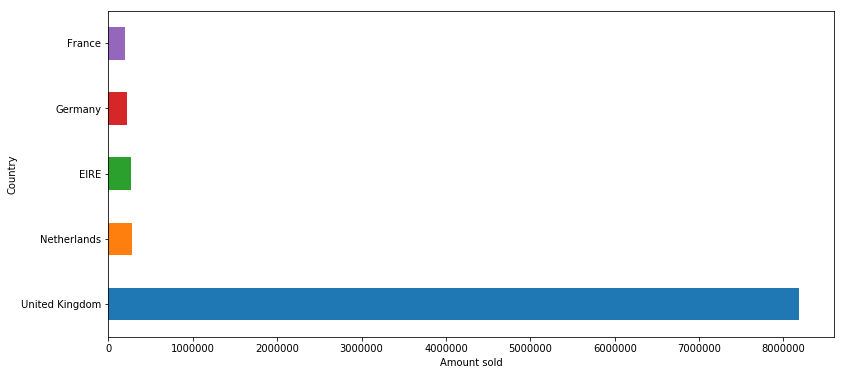

In [228]:
df.groupby('Country')['Amount'].sum().sort_values(ascending=False).head(n=5).plot.barh(figsize=(13,6))
plt.xlabel('Amount sold')
plt.show()

As expected, we can see that the UK accounts for the largest amount of sales, with over **8,000,000**(in monetary units).
Other European countries are not exactly close by, but they trail it by a significant amount.
 <div id="uk_logic"></div>

### Investigating customers

How many unique customers are we dealing with in this scenario?

In [229]:
len(df.CustomerID.unique())

4373

With **just over 4300** customers to keep in mind, we can start off by investigating **how much** each one accounts for our transactions.

In [230]:
df.groupby(['CustomerID','Country'])['Amount'].sum().sort_values(ascending=False).head(n=10)

CustomerID  Country       
14646.0     Netherlands       279489.02
18102.0     United Kingdom    256438.49
17450.0     United Kingdom    187482.17
14911.0     EIRE              132572.62
12415.0     Australia         123725.45
14156.0     EIRE              113384.14
17511.0     United Kingdom     88125.38
16684.0     United Kingdom     65892.08
13694.0     United Kingdom     62653.10
15311.0     United Kingdom     59419.34
Name: Amount, dtype: float64

Interestingly enough, the customer who has **spent the most** is not from the UK, but is rather based out of Netherlands.
Another measure of value is **the number of occurences** of each customer.

In [231]:
((df.CustomerID.value_counts()/df.CustomerID.value_counts().sum())*100).cumsum().head(n=15)

17841.0     1.962249
14911.0     3.413228
14096.0     4.673708
12748.0     5.814728
14606.0     6.498553
15311.0     7.110850
14646.0     7.623350
13089.0     8.079807
13263.0     8.492020
14298.0     8.895138
15039.0     9.265809
14156.0     9.614850
18118.0     9.930462
14159.0    10.228376
14796.0    10.514737
Name: CustomerID, dtype: float64

It seems that **only 15 customers** account for **10% of all data** in this dataset.

### Inventory discrepancies

Let's quickly investigate our stock and look for any mismatches.

In [232]:
print("Number of Stock codes: {} \t Number of Descriptions:{}".format(len(df.StockCode.unique()),
                                                                       len(df.Description.unique())))

Number of Stock codes: 4070 	 Number of Descriptions:4224


Claerly, we have **multiple descriptions** for the same stock item. Let's find out what is exactly going on here.

In [233]:
stock_df = df.groupby(['StockCode','Description']).count().reset_index()
stock_df.head(n=10)

,StockCode,Description,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,10002,INFLATABLE POLITICAL GLOBE,71,71,71,71,49,71,71
1,10080,GROOVY CACTUS INFLATABLE,22,22,22,22,21,22,22
2,10080,check,1,1,1,1,0,1,1
3,10120,DOGGY RUBBER,30,30,30,30,30,30,30
4,10125,MINI FUNKY DESIGN TAPES,94,94,94,94,64,94,94
5,10133,COLOURING PENCILS BROWN TUBE,199,199,199,199,125,199,199
6,10133,damaged,1,1,1,1,0,1,1
7,10135,COLOURING PENCILS BROWN TUBE,180,180,180,180,122,180,180
8,11001,ASSTD DESIGN RACING CAR PEN,120,120,120,120,69,120,120
9,15030,FAN BLACK FRAME,13,13,13,13,13,13,13


The condition we are interested in investigating is:

In [234]:
cond = stock_df.StockCode.value_counts() >1
len(stock_df.StockCode.value_counts()[cond])

650

It appears that **650 items** have multiple descriptions.Let's define a helper function to neatly print out the **different descriptions** for an item with a particular StockCode.

In [235]:
multiple_stock_df = stock_df.StockCode.value_counts()[cond].reset_index()
multiple_stock_df.set_index('index',inplace = True)
stock_df.set_index('StockCode',inplace = True)

In [236]:
def multiple_name_printer(name_array):
    i = 1
    for name in name_array:
        print(str(i) + ") {}".format(name))
        i = i+1

Call the function with the **appropriate array**.

In [237]:
#Select which element to access, out of the 650 multiple-description items
i = 560  # i in [0,649]

multiple_name_printer(stock_df.loc[multiple_stock_df.index[i]].Description.unique())

1) TWO DOOR CURIO CABINET
2) damages


Now,let's move on to the next section, where we take a glance at our most **successful items**.

## <div id="1.2">1.2:  Item and Time analysis</div>


It is time to take a look at our most **well-performing** items.

In [238]:
item_sales_df = df.groupby('Description')[['Amount','Quantity']].sum().sort_values('Amount',ascending = False).reset_index()
item_sales_df.head(n = 10)

,Description,Amount,Quantity
0,DOTCOM POSTAGE,206245.48,707
1,REGENCY CAKESTAND 3 TIER,164762.19,13033
2,WHITE HANGING HEART T-LIGHT HOLDER,99668.47,35317
3,PARTY BUNTING,98302.98,18022
4,JUMBO BAG RED RETROSPOT,92356.03,47363
5,RABBIT NIGHT LIGHT,66756.59,30680
6,POSTAGE,66230.64,3003
7,PAPER CHAIN KIT 50'S CHRISTMAS,63791.94,18902
8,ASSORTED COLOUR BIRD ORNAMENT,58959.73,36381
9,CHILLI LIGHTS,53768.06,10229


Items such as **DOTCOM POSTAGE, PARTY BUNTING, etc.** account for the largest contribution towards total **sales amount**. Let's visualize this very quickly.

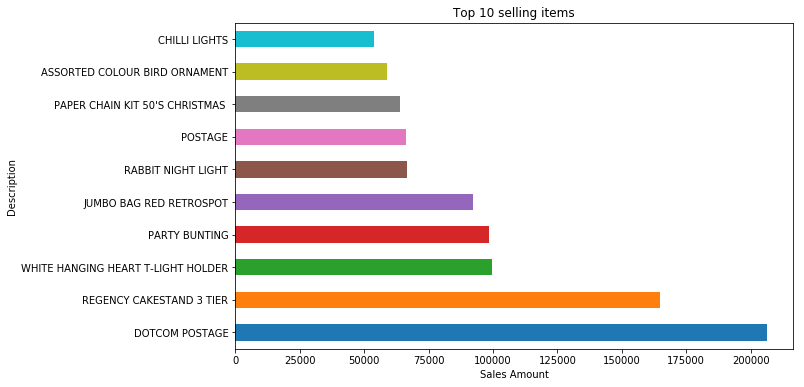

In [239]:
item_sales_df.set_index('Description').Amount.head(n=10).plot.barh(figsize = (10,6))
plt.xlabel('Sales Amount')
plt.title('Top 10 selling items')
plt.show()

What about **Quantity sold**?

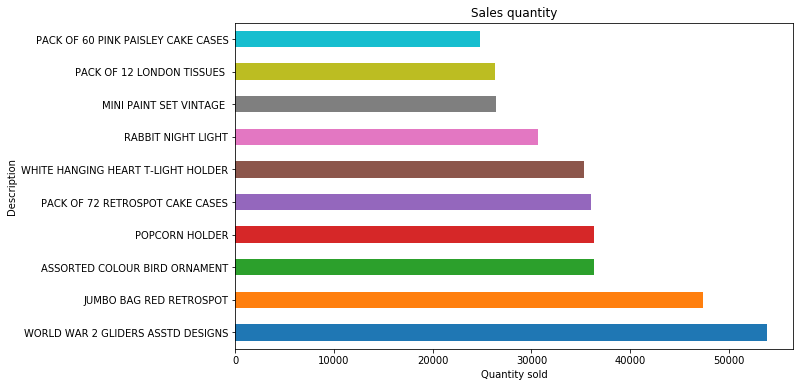

In [240]:
item_sales_df.set_index('Description').Quantity.sort_values(ascending=False).head(n=10).plot.barh(figsize = (10,6))
plt.xlabel('Quantity sold')
plt.title('Sales quantity')
plt.show()

It appears that there is a clear difference in the two top-10 lists we have visualized so far in this section. This is completely understandable, since the **UnitPrice** effectively plays a key role in the **Amount** made in each transaction with the item.

Do we have any **non-positive values** in our dataset though?

In [241]:
df[df['Quantity']<0].sort_values('Quantity',ascending = True).set_index('Description').head(n=10).Quantity

Description
PAPER CRAFT , LITTLE BIRDIE           -80995
MEDIUM CERAMIC TOP STORAGE JAR        -74215
printing smudges/thrown away           -9600
printing smudges/thrown away           -9600
ROTATING SILVER ANGELS T-LIGHT HLDR    -9360
Printing smudges/thrown away           -9058
throw away                             -5368
Unsaleable, destroyed.                 -4830
NaN                                    -3667
NaN                                    -3167
Name: Quantity, dtype: int64

These inventory items are **negative** in terms of Quantity traded, meaning they were most likely **returned** or simply **damaged**. We can clean up these entries in the next section. But let's check if we have the same issue with **UnitPrice**.

In [242]:
df[df['UnitPrice'] < 0].shape

(2, 9)

There are only two rows with this condition, so let's view them.

In [243]:
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,-11062.06
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,-11062.06


It certainly makes sense now that we see the **Description** and it explicitly tells us that the store simply had to account for **Bad debts**.

## Time Analysis

Let's quickly investigate how our transactions have **varied over the course of the year**.

In [244]:
time_analysis_df = df.groupby('InvoiceDate')[['Amount','Quantity']].sum().reset_index()
time_analysis_df.head()

,InvoiceDate,Amount,Quantity
0,2010-12-01 08:26:00,139.12,40
1,2010-12-01 08:28:00,22.20,12
2,2010-12-01 08:34:00,348.78,98
3,2010-12-01 08:35:00,17.85,3
4,2010-12-01 08:45:00,855.86,449


Let's define some helper functions to investigate the **timestamps** further.

In [245]:
def map_out_month(time_stamp):
    return time_stamp.month


def map_out_day(time_stamp):
    return time_stamp.day


def map_out_hour(time_stamp):
    return time_stamp.hour


def map_out_minute(time_stamp):
    return time_stamp.minute

In [246]:
time_analysis_df['Month'] = time_analysis_df['InvoiceDate'].apply(map_out_month)

time_analysis_df['Day'] = time_analysis_df['InvoiceDate'].apply(map_out_day)

time_analysis_df['Hour'] = time_analysis_df['InvoiceDate'].apply(map_out_hour)

time_analysis_df['Minute'] = time_analysis_df['InvoiceDate'].apply(map_out_minute)


time_analysis_df.head()

,InvoiceDate,Amount,Quantity,Month,Day,Hour,Minute
0,2010-12-01 08:26:00,139.12,40,12,1,8,26
1,2010-12-01 08:28:00,22.20,12,12,1,8,28
2,2010-12-01 08:34:00,348.78,98,12,1,8,34
3,2010-12-01 08:35:00,17.85,3,12,1,8,35
4,2010-12-01 08:45:00,855.86,449,12,1,8,45


In [247]:
time_analysis_df.tail()

,InvoiceDate,Amount,Quantity,Month,Day,Hour,Minute
23255,2011-12-09 12:23:00,124.60,76,12,9,12,23
23256,2011-12-09 12:25:00,140.64,120,12,9,12,25
23257,2011-12-09 12:31:00,329.05,278,12,9,12,31
23258,2011-12-09 12:49:00,339.20,66,12,9,12,49
23259,2011-12-09 12:50:00,249.45,105,12,9,12,50


For how many hours is our store actually **open for transactions**?

In [248]:
len(time_analysis_df.Hour.unique())

15

Do we have an even distribution of data across all 12 months?

In [249]:
time_analysis_df.Month.value_counts()

11    3029
12    2669
10    2358
9     2097
5     1931
6     1825
3     1808
7     1735
8     1608
4     1540
1     1349
2     1311
Name: Month, dtype: int64

Considering the fact that the dataset accounts for all transactions over the course of a year, starting in **December 2010** and ending all the way in **December 2012**, it's understandable that the last month of the year accounts for a large number of transactions (**2669** entries).

November is **the busiest** month (it is indeed close to **Christmas** and also contains **Thanksgiving** which is celebrated in November in the UK).

### Visual analysis

Let's visualize some **trends over time** for our data.

We can define a dictionary and **store the respective** month associated with each label (1,2,... 12).

In [250]:
month_dict ={1:'January',2:'February',3:'March',4:'April',
            5:'May',6:'June',7:'July',8:'August',
            9:'September',10:'October',11:'November',12:'December'}

Using a function, we can plot a **line chart** for **daily total sales amount** for two given months. The required paramters are two valid values of month (**[1,12]**) and the resultant plot is demonstrated below.

In [251]:
def plot_daily_sales_by_month(month_1, month_2):
    plt.figure(figsize=(13,8))
    
    time_analysis_df[time_analysis_df['Month']==month_1].groupby('Day')['Amount'].sum().plot.line(label=month_dict[month_1])
    time_analysis_df[time_analysis_df['Month']==month_2].groupby('Day')['Amount'].sum().plot.line(label=month_dict[month_2])
    plt.xlabel('Day')
    plt.ylabel('Sales amount')
    plt.title('Daily Total Sales')
    plt.legend()
    plt.show()

How do the daily sales compare between **November and May**?

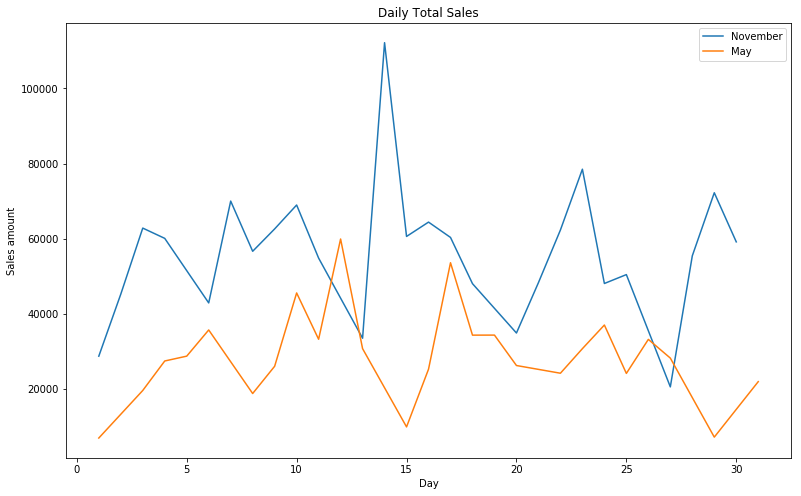

In [252]:
plot_daily_sales_by_month(11,5)

What if we want to visualize **minute-by-minute** sales amount variation for a **given month, on a given day, within 1 hour**?

In [253]:
def plot_min_by_min_sales(month, day, hour):
    try:
         plt.figure(figsize=(20,5))
    
         cond = (time_analysis_df.Month==month) & (time_analysis_df['Day'] == day) & (time_analysis_df['Hour'] == hour)
    
         time_analysis_df[cond].groupby('Minute')['Amount'].sum().plot.line(label="Hourly Sales amount")
        
        #Customize label
         str_label ="Minutes on {}th {} between {}:00 and {}:00".format(day, month_dict[month],
                                                            hour, hour+1)
         plt.xlabel(str_label)
         plt.ylabel('Sales amount')
         plt.title('Minute-by-Minute sales variation')
         plt.legend()
         plt.show()
   
    #Deal with Exception
    except TypeError:
        print("Invalid Input Value!")

Using this function, we can easily analyze the sales variation according to our needs.

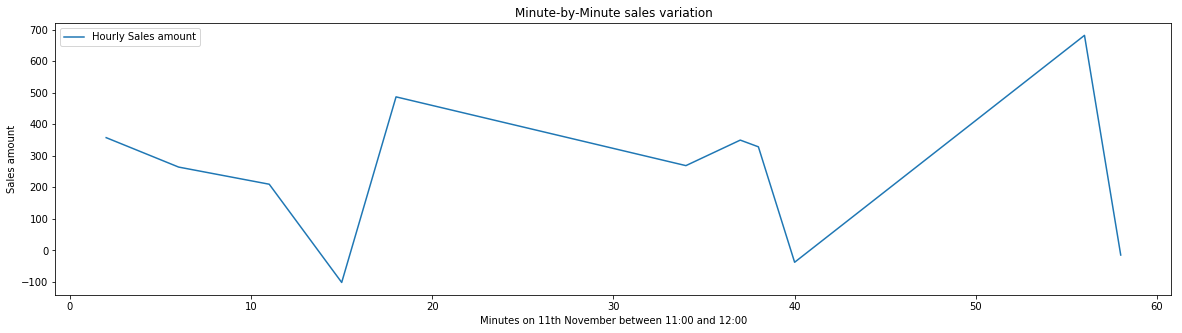

In [254]:
chosen_month = 11

chosen_day = 11

chosen_hour = 11

#Call
plot_min_by_min_sales(chosen_month, chosen_day, chosen_hour)

With this function, we can inspect the sales of the retail store on a very **strictly-timed basis**. Let's move on now, to cleaning up our data a bit before heading off into **Section 2**.

## <div id="1.3">1.3:  Return transactions & Missing Data</div>


Recall that we have some return transactions and **Bad debts** to deal with. Do we have any **missing data** though?

In [255]:
#Helper function to summarize missing data
def missing_data_info(df):
    total_miss_obs_count = df.isnull().sum().sort_values(ascending=False)
    missing_prcnt = ((df.isnull().sum()/ df.isnull().count())*100).sort_values(ascending=False)
    out_df = pd.concat([total_miss_obs_count, missing_prcnt],axis =1,
                       keys =['Missing #', 'Missing %'])
    return out_df

#Call
missing_data_info(df)


,Missing #,Missing %
CustomerID,135080,24.926694
Description,1454,0.268311
Amount,0,0.000000
Country,0,0.000000
UnitPrice,0,0.000000
InvoiceDate,0,0.000000
Quantity,0,0.000000
StockCode,0,0.000000
InvoiceNo,0,0.000000


It appears that we have plenty of missing information for **CustomerID**, and there really isn't any logical way to **impute** values for this variable. Recall from <a href="#uk_logic"> section 1.1.</a> that the United Kingdom accounts for most of our data, so we can subset our DataFrame even further so that it only includes transactions from this region.

To deal with the issue of missing data and this regional bias, let's do the following:

In [256]:
#Remove return transactions
df= df[~(df.Amount < 0)]
#Drop unidentifiable customers
df= df[~(df.CustomerID.isnull())]  #NOTE the Negation

#keep only UK-based transactions
df= df[df.Country=='United Kingdom']  #NOTE the Negation

In [257]:
df.shape

(354345, 9)

In [258]:
missing_data_info(df)

,Missing #,Missing %
Amount,0,0.0
Country,0,0.0
CustomerID,0,0.0
UnitPrice,0,0.0
InvoiceDate,0,0.0
Quantity,0,0.0
Description,0,0.0
StockCode,0,0.0
InvoiceNo,0,0.0


We have drastically reduced our data. By how much exactly?

In [259]:
df_copy.shape[0]-df.shape[0]

187564

We have **dropped 187,564** transactional rows and we shall keep this in mind, as we move forward into our **Feature Engineering** section.

# <div id="sec 2">Section 2: Feature Engineering</div>


In order to segment our customers into distinct groups, we need some sort of basis on which we can quantify them. We can create three new features for this very purpose.

Let's make **ANOTHER copy** of our dataset so far:

In [260]:
df_post_1 = df.copy()

## <div id="2.1">2.1:  Recency</div>


How recently have we done business with a given customer? 6 months ago? 6 days ago? A customer who has recently visited us might come around again very soon and in order to maximize the possible profit from such a visit, we should be able to **identify** such customers.

To do this, we must identify a **reference date** against which we can measure this metric. What is the **last recorded day** in our dataset?

In [261]:
df.InvoiceDate.max()

Timestamp('2011-12-09 12:49:00')

Let's define this **reference day** as one day *AFTER* the **last day**.

In [262]:
reference_date = df.InvoiceDate.max() + datetime.timedelta(days=1)
reference_date

Timestamp('2011-12-10 12:49:00')

Let's add this feature.

In [263]:
# Find recency          #Last - Date
df['days_since_last'] = reference_date - df.InvoiceDate 
df['days_since_last'] = df['days_since_last'].astype('timedelta64[D]')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,days_since_last
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,374.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,374.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374.0


In [264]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,days_since_last
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,23.4,1.0
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,23.6,1.0
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,30.0,1.0
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,214.8,1.0
541893,581586,20685,DOORMAT RED RETROSPOT,10,2011-12-09 12:49:00,7.08,13113.0,United Kingdom,70.8,1.0


Let's get this feature seperately, grouped by **Customers**.

In [265]:
recency_df = df.groupby('CustomerID')['days_since_last'].min().reset_index().sort_values('days_since_last',ascending = True)
recency_df.rename(columns ={'days_since_last':'Recency'}, inplace = True)

recency_df.head()

,CustomerID,Recency
1795,15344.0,1.0
3373,17528.0,1.0
2727,16626.0,1.0
759,13890.0,1.0
2957,16933.0,1.0


Which customers last dealt with us **a long while ago**?

In [266]:
recency_df.tail()

,CustomerID,Recency
3691,17968.0,374.0
3763,18074.0,374.0
3647,17908.0,374.0
662,13747.0,374.0
1355,14729.0,374.0


Let's visualize the **distribution** of Recency using **Seaborn**.

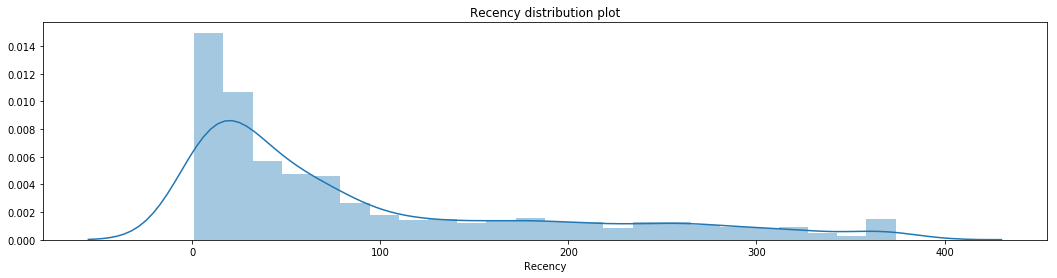

In [267]:
plt.figure(figsize=(18,4))
sn.distplot(recency_df['Recency'])
plt.title("Recency distribution plot")
plt.show()

We have a **right-skewed** distribution, and this indicates that we must deal with this before we implement our clustering algorithm.

## <div id="2.2">2.2:  Frequency</div>


**How often** do our customers actually do transactions with the retail store? This key metric will add another dimension of value to a given individual.

In [268]:
frequency_df = df.CustomerID.value_counts().reset_index()

frequency_df.rename(columns = {'index': 'CustomerID', 'CustomerID':'Frequency'},
                   inplace = True)
frequency_df.head(n=10)

,CustomerID,Frequency
0,17841.0,7847
1,14096.0,5111
2,12748.0,4596
3,14606.0,2700
4,15311.0,2379
5,13089.0,1818
6,13263.0,1677
7,14298.0,1637
8,15039.0,1502
9,18118.0,1279


In [269]:
frequency_df.shape

(3921, 2)

Among **3921** customers, we can see our most-active customers above. Let's quickly utilize Seaborn once more and visualize this.

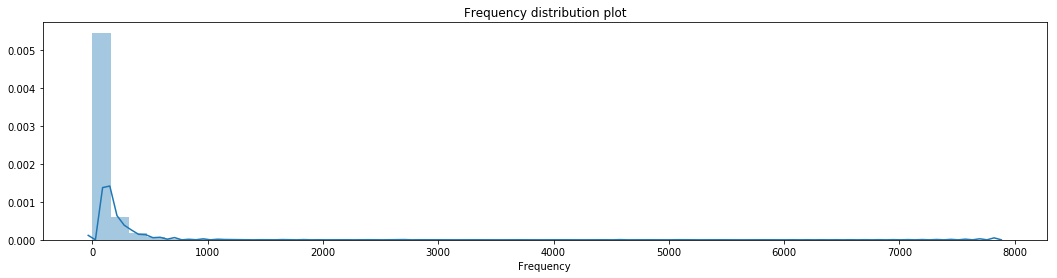

In [270]:
plt.figure(figsize=(18,4))
sn.distplot(frequency_df['Frequency'])
plt.title("Frequency distribution plot")
plt.show()

That looks highly disturbing if we think about directly feeding this to our clustering algorithm in Section 3. We must deal with this as well in **Section 2.4**.

## <div id="2.3">2.3: Monetary Value</div>


Let's find out each customer's **total contribution** to our store's Sales and hence find their **Monetary Value** to us.

In [271]:
monetary_value_df = df.groupby('CustomerID')['Amount'].sum().reset_index().sort_values('Amount', ascending=False)
monetary_value_df.rename(columns ={'Amount': 'Monetary_Value'}, inplace = True)
monetary_value_df.head(n=10)

,CustomerID,Monetary_Value
3784,18102.0,259657.30
3315,17450.0,194550.79
2599,16446.0,168472.50
3357,17511.0,91062.38
2295,16029.0,81024.84
0,12346.0,77183.60
2767,16684.0,66653.56
903,14096.0,65164.79
621,13694.0,65039.62
1772,15311.0,60767.90


Here, we can clearly see the 10 customers who carry the most **value** for the store, from a business transactional standpoint.

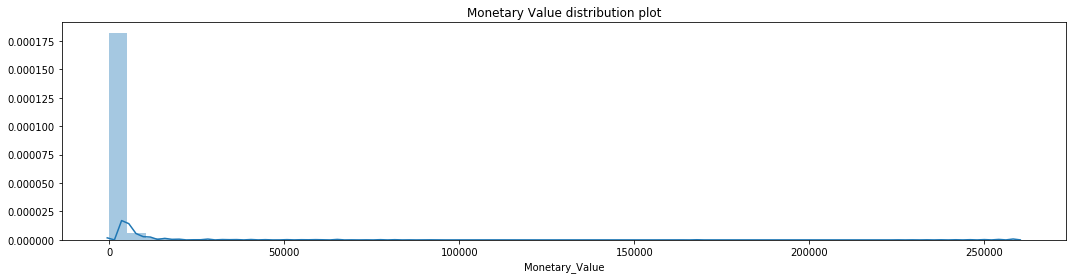

In [272]:
plt.figure(figsize=(18,4))
sn.distplot(monetary_value_df['Monetary_Value'])
plt.title("Monetary Value distribution plot")
plt.show()

Plenty of **high-value** outliers are present, as in the last two features.

Now that we have our three discernable features, let's go ahead and **Preprocess** them before implementing our **Clustering Algorithm**.

## <div id="2.4">2.4:  Data preprocessing</div>


First order of business; **MERGE** the 3 newly created Features.

In [273]:
customer_matrix = recency_df.merge(frequency_df, how='outer')
customer_matrix = customer_matrix.merge(monetary_value_df, how='outer')
customer_matrix.head(n=10)

,CustomerID,Recency,Frequency,Monetary_Value
0,15344.0,1.0,26,563.94
1,17528.0,1.0,253,3628.50
2,16626.0,1.0,179,4413.10
3,13890.0,1.0,110,1883.81
4,16933.0,1.0,44,563.23
5,13860.0,1.0,76,1245.90
6,13798.0,1.0,349,37153.85
7,13777.0,1.0,197,25977.16
8,16954.0,1.0,54,2085.08
9,17491.0,1.0,109,3558.87


In [274]:
customer_matrix.shape

(3921, 4)

As we can see, we have a row for each customer in our **Matrix**, which we must now **(numerically) clean**. In order to obtain a Matrix of Features with **Homogenous and scaled data**, we must deal with the massive outliers that we observed in the previous sections. 

We must carry out two steps: **Standardization** and **Logarithmic Transformations**(consider the fact that the feature **Monetary Value** consisted of a **huge possible range** of values).

### Log transform

Before applying the log transformation on our features, let's check for any **non-positive** values. If we find any, we can simply add a **small value** to cast it as positive.

In [275]:
customer_matrix.eq(0).any()

CustomerID        False
Recency           False
Frequency         False
Monetary_Value     True
dtype: bool

We do have some **negative(or 0)** values for Monetary Value, so let's deal with them accordingly.

In [276]:
customer_matrix['Monetary_Value'] = customer_matrix['Monetary_Value']+  0.001  #Very minute amount

Import scikit learn's **Preprocessing** module.

In [277]:
from sklearn import preprocessing

Apply the **Logarithmic transformations**.

In [278]:
#Define new log-transformed features
customer_matrix['Recency_log'] = customer_matrix['Recency'].apply(math.log) 
customer_matrix['Frequency_log'] = customer_matrix['Frequency'].apply(math.log) 
customer_matrix['Monetary_Value_log'] = customer_matrix['Monetary_Value'].apply(math.log) 

#Specify the vector of features
features = ['Recency_log', 'Frequency_log', 'Monetary_Value_log']

customer_matrix[features].head(n=10)

,Recency_log,Frequency_log,Monetary_Value_log
0,0.0,3.258097,6.334950
1,0.0,5.533389,8.196575
2,0.0,5.187386,8.392333
3,0.0,4.700480,7.541052
4,0.0,3.784190,6.333690
5,0.0,4.330733,7.127614
6,0.0,5.855072,10.522823
7,0.0,5.283204,10.164973
8,0.0,3.988984,7.642563
9,0.0,4.691348,8.177199


Let's observe the difference in the distributions of our **3 features** after the log transformation.

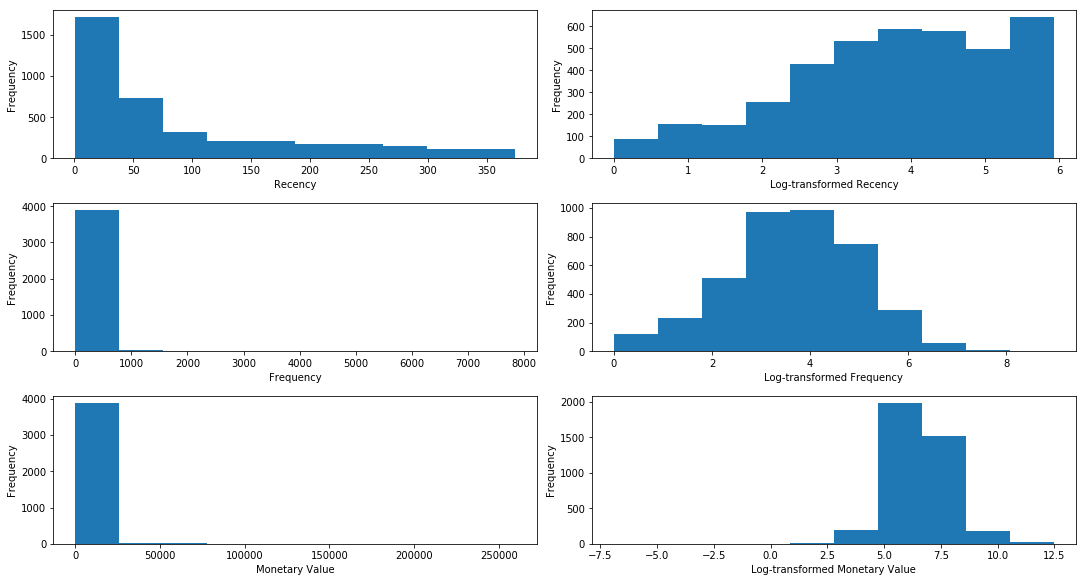

In [279]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)


#Compare Recency
customer_matrix.Recency.plot.hist(ax=ax1, figsize=(15,8))
ax1.set_xlabel('Recency', fontsize=10)
customer_matrix.Recency_log.plot.hist(ax=ax2 , figsize=(15,8))
ax2.set_xlabel('Log-transformed Recency', fontsize=10)

#Compare Frequency
customer_matrix.Frequency.plot.hist(ax=ax3, figsize=(15,8))
ax3.set_xlabel('Frequency', fontsize=10)
customer_matrix.Frequency_log.plot.hist(ax=ax4 , figsize=(15,8))
ax4.set_xlabel('Log-transformed Frequency', fontsize=10)

#Compare Monetary Value
customer_matrix.Monetary_Value.plot.hist(ax=ax5, figsize=(15,8))
ax5.set_xlabel('Monetary Value', fontsize=10)
customer_matrix.Monetary_Value_log.plot.hist(ax=ax6 , figsize=(15,8))
ax6.set_xlabel('Log-transformed Monetary Value', fontsize=10)



#Fix layout
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.show()

### Standardization

In order to Standardize the data (**Mean =0, Variance = 1**), we can first define our **Matrix of logarithmic-values** explicitly and then implement the **Standard Scaler** on it.

In [280]:
X_unscaled = customer_matrix[features].as_matrix()

#Fit the Scaler and Standardize the features
scaler_ob = preprocessing.StandardScaler()
scaler_ob.fit(X_unscaled)
#Define the SCALED matrix of features
X_scaled = scaler_ob.transform(X_unscaled)

With our completely *standardized* matrix of features, we are ready to move onto the implementation of our **Unsupervised Clustering Algorithm**!

# <div id="sec 3">Section 3: K-Means Clustering </div>


In [281]:
from mpl_toolkits.mplot3d import Axes3D

Let's start this section with a **Three-dimensional view** of our Customers based on the three metrics we created in **Section 2**.

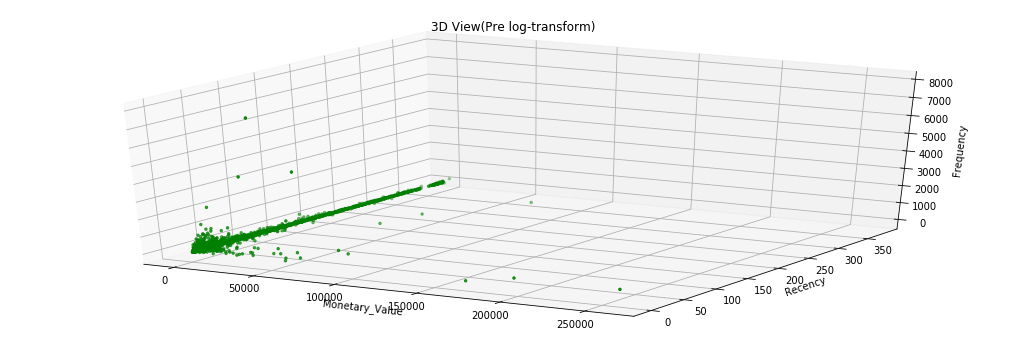

In [282]:
fig = plt.figure(figsize = (18,6))
ax = fig.add_subplot(111,projection ='3d')

#Create x,y,z
xs = customer_matrix['Monetary_Value']
ys = customer_matrix['Recency']
zs = customer_matrix['Frequency']
ax.scatter(xs,ys,zs,s=6,c= 'green')

ax.set_xlabel('Monetary_Value')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

plt.title("3D View(Pre log-transform)")
plt.show()

And now, to witness the effect of our **preprocessing** once more...

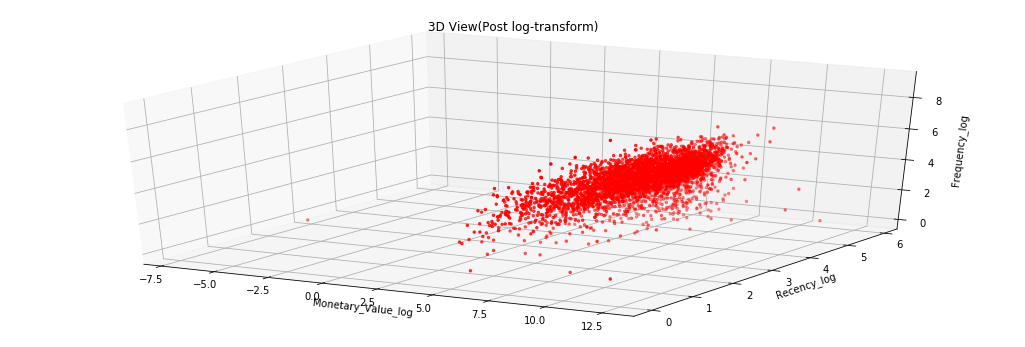

In [283]:
fig = plt.figure(figsize = (18,6))
ax = fig.add_subplot(111,projection ='3d')

#Create x,y,z
xs = customer_matrix['Monetary_Value_log']
ys = customer_matrix['Recency_log']
zs = customer_matrix['Frequency_log']
ax.scatter(xs,ys,zs,s=6,c='red')

ax.set_xlabel('Monetary_Value_log')
ax.set_ylabel('Recency_log')
ax.set_zlabel('Frequency_log')

plt.title("3D View(Post log-transform)")
plt.show()

Let's go ahead and implement our model.

## <div id="3.1">3.1:  Finding three prime clusters</div>


There are methods of finding the **optimal number of clusters** for our KMeans algorithm, but after some trial and error, I found that an intuitively effective number of clusters was **3**.

We can stratify customers into three distinct classes: Low-value, High-value and *Ordinary*.

Let's train the model and find the clusters.

In [284]:
from sklearn.cluster import KMeans

#See reasoning above for 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_scaled)
y_kmeans = kmeans.predict(X_scaled)

And at long last, we can **visualize** our clusters clearly here.

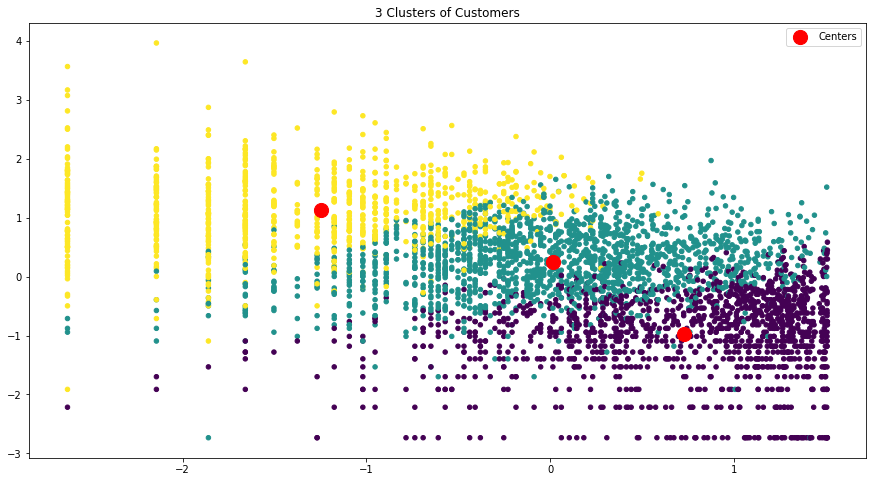

In [285]:
plt.figure(figsize=(15,8))

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_kmeans, s=20, cmap='viridis')


#Plot the centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=1,label="Centers");
plt.legend()
plt.title("3 Clusters of Customers")
plt.show()

Let's visualize the clusters (**Log-transformed data points**) on a 3-dimensional plot once more.

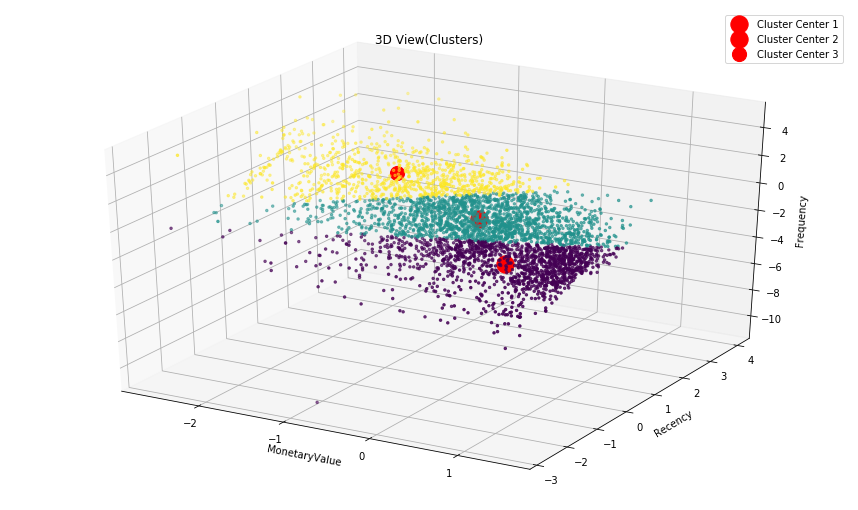

In [286]:
#%matplotlib notebook


fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(111,projection ='3d')

#Create x,y,z
xs = X_scaled[:,0]   #Recency
ys = X_scaled[:,1]   #Frequency
zs = X_scaled[:,2]   #Monetary Value
ax.scatter(xs,ys,zs,s=6,c= y_kmeans)

#Centers
ax.scatter(centers[0][0], centers[0][1], centers[0][2], c='red', s=300, alpha=1,label="Cluster Center 1");
ax.scatter(centers[1][0], centers[1][1], centers[1][2], c='red', s=300, alpha=1,label="Cluster Center 2");
ax.scatter(centers[2][0], centers[2][1], centers[2][2], c='red', s=200, alpha=1,label="Cluster Center 3");



ax.set_xlabel('MonetaryValue')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

plt.legend()
plt.title("3D View(Clusters)")
plt.show()

Incredible! We can see our three customer clusters above, each with it's unique center. Let's inspect the **un-standardized and un-transformed** cluster centers.

In [287]:
#Standardized
centers

array([[ 0.72623993, -0.96706494, -0.90233103],
       [ 0.01268604,  0.2422692 ,  0.15423543],
       [-1.24648005,  1.13621277,  1.20525348]])

In [288]:
#Exponentiate to get inverse of log-transform
un_transformed_centers = np.exp(scaler_ob.inverse_transform(centers))
un_transformed_centers

array([[  122.08865396,    10.65557867,   221.00243464],
       [   43.89916657,    53.82913067,   841.26854587],
       [    7.22053507,   178.23896412,  3179.97450994]])

We can construct a dataframe from these values as well...

In [289]:
three_clusters_centers_df = pd.DataFrame(un_transformed_centers,
                                         columns =['Recency','Frequency','Monetary_Value'])
three_clusters_centers_df.rename(index={0:'Cluster 1',
                                       1:'Cluster 2',
                                       2:'Cluster 3'},inplace=True)
three_clusters_centers_df

,Recency,Frequency,Monetary_Value
Cluster 1,122.088654,10.655579,221.002435
Cluster 2,43.899167,53.829131,841.268546
Cluster 3,7.220535,178.238964,3179.974510


Let's break this down:
<ul>
  <li>Cluster 3 contains some very high-value customers who tend to spend a large amount while doing transactions with the retail store, and they tend to do so very frequently </li>
  <li>Cluster 2 contains customers who have been dealing with the store most recently, but they are not so frequent and indeed do not spend too much money</li>
  <li>Customers in cluster 1 are rather frequent and spend a decent amount when they deal with the store, but have not been dealing with us very recently per se</li>
</ul>


## <div id="3.2">3.2:  Analyzing the clusters</div>


To wrap up our analysis, we can classify our customers according to the cluster they belong to and plot some **Boxplots** to inspect the distribution of **Recency, Frequency and Monetary Value**.

In [290]:
customer_matrix.head()

,CustomerID,Recency,Frequency,Monetary_Value,Recency_log,Frequency_log,Monetary_Value_log
0,15344.0,1.0,26,563.941,0.0,3.258097,6.334950
1,17528.0,1.0,253,3628.501,0.0,5.533389,8.196575
2,16626.0,1.0,179,4413.101,0.0,5.187386,8.392333
3,13890.0,1.0,110,1883.811,0.0,4.700480,7.541052
4,16933.0,1.0,44,563.231,0.0,3.784190,6.333690


Let's **label each customer** appropriately:

In [291]:
kmeans.labels_

array([2, 2, 2, ..., 0, 0, 0])

In [292]:
labels = pd.DataFrame(kmeans.labels_,columns=['Cluster_Label'])
labels.head()

,Cluster_Label
0,2
1,2
2,2
3,2
4,2


Considering the fact that we have **three clusters**, let's avoid 0-indexing and directly label them as Cluster 1/2/3.

In [293]:
customer_matrix['Cluster_Label'] = labels + 1
customer_matrix.head(n=10)

,CustomerID,Recency,Frequency,Monetary_Value,Recency_log,Frequency_log,Monetary_Value_log,Cluster_Label
0,15344.0,1.0,26,563.941,0.0,3.258097,6.334950,3
1,17528.0,1.0,253,3628.501,0.0,5.533389,8.196575,3
2,16626.0,1.0,179,4413.101,0.0,5.187386,8.392333,3
3,13890.0,1.0,110,1883.811,0.0,4.700480,7.541052,3
4,16933.0,1.0,44,563.231,0.0,3.784190,6.333690,3
5,13860.0,1.0,76,1245.901,0.0,4.330733,7.127614,3
6,13798.0,1.0,349,37153.851,0.0,5.855072,10.522823,3
7,13777.0,1.0,197,25977.161,0.0,5.283204,10.164973,3
8,16954.0,1.0,54,2085.081,0.0,3.988984,7.642563,3
9,17491.0,1.0,109,3558.871,0.0,4.691348,8.177199,3


In [294]:
customer_matrix.groupby('Cluster_Label')['Monetary_Value'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster_Label,,,,,,,,
1,1402.0,286.229374,252.868388,0.001,144.9335,231.481,349.9710,4055.721
2,1682.0,1157.222571,2490.575417,120.031,533.6885,809.036,1330.4685,77183.601
3,837.0,5926.706723,15106.324264,310.641,1822.9710,2837.671,5045.6110,259657.301


Let's try drawing a boxplot of the amount spent by customers in each cluster.

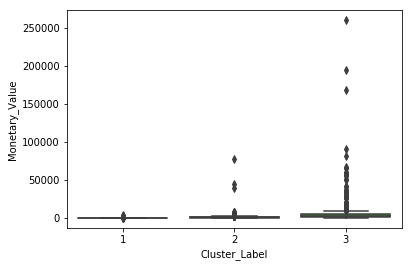

In [295]:
sn.boxplot(data = customer_matrix[['Cluster_Label','Monetary_Value']],
          x='Cluster_Label',
          y= 'Monetary_Value')
plt.show()

That looks quite disturbing. Recall that we have **high-value** outliers, so we can more closely just inspect the **80th percentile** by itself.

In [296]:
#Cluster 1
y_1_mv = customer_matrix['Monetary_Value'][customer_matrix['Cluster_Label']==1]

#Observe only data below the 80th percentile
y_1_mv = y_1_mv[y_1_mv < np.percentile(y_1_mv, 80)]

#Cluster 2
y_2_mv = customer_matrix['Monetary_Value'][customer_matrix['Cluster_Label']==2]

#Observe only data below the 80th percentile
y_2_mv = y_2_mv[y_2_mv < np.percentile(y_2_mv, 80)]


#Cluster 3
y_3_mv = customer_matrix['Monetary_Value'][customer_matrix['Cluster_Label']==3]

#Observe only data below the 80th percentile
y_3_mv = y_3_mv[y_3_mv < np.percentile(y_3_mv, 80)]

Let's construct a DataFrame which we can use for plotting the boxplots of each cluster.

In [297]:
plotting_data_df = customer_matrix
#Add to the DataFrame
plotting_data_df['y1_under_80'] = pd.DataFrame(y_1_mv)
plotting_data_df['y2_under_80'] = pd.DataFrame(y_2_mv)
plotting_data_df['y3_under_80'] = pd.DataFrame(y_3_mv)

#Fill NA values with 0
plotting_data_df = plotting_data_df.fillna(0)
plotting_data_df.head()

,CustomerID,Recency,Frequency,Monetary_Value,Recency_log,Frequency_log,Monetary_Value_log,Cluster_Label,y1_under_80,y2_under_80,y3_under_80
0,15344.0,1.0,26,563.941,0.0,3.258097,6.334950,3,0.0,0.0,563.941
1,17528.0,1.0,253,3628.501,0.0,5.533389,8.196575,3,0.0,0.0,3628.501
2,16626.0,1.0,179,4413.101,0.0,5.187386,8.392333,3,0.0,0.0,4413.101
3,13890.0,1.0,110,1883.811,0.0,4.700480,7.541052,3,0.0,0.0,1883.811
4,16933.0,1.0,44,563.231,0.0,3.784190,6.333690,3,0.0,0.0,563.231


Let's define a quick helper function to obtain the appropriate value to plot(**Monetary_Value** in this case) for each row in the DataFrame.

In [298]:
def map_clusters(row):
    #Retrun the value for Cluster 1
    if row['Cluster_Label']==1:
        return row['y1_under_80']
    #Retrun the value for Cluster 2
    elif row['Cluster_Label']==2:
        return row['y2_under_80']
    else:
        return row['y3_under_80']

We can now go ahead and apply this function on our entire DataFrame in one step:

In [299]:
plotting_data_df['Monetary_Plot'] = plotting_data_df.apply(map_clusters, axis=1)

Finally, we can plot it using **Seaborn**.

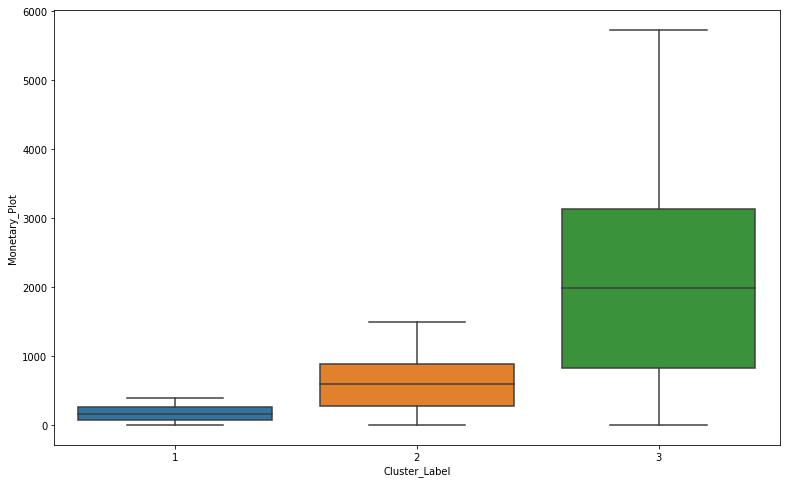

In [300]:
plt.figure(figsize=(13,8))

sn.boxplot(data= plotting_data_df,
          x='Cluster_Label',
          y='Monetary_Plot')
plt.show()

Following the logic above, let's **encapsulate** the steps into a single plotting function. 

In [301]:
def map_and_setup_boxplots(str_feature):
    try:
    #Cluster 1
      y_1_mv = customer_matrix[str_feature][customer_matrix['Cluster_Label']==1]

#Observe only data below the 80th percentile
      y_1_mv = y_1_mv[y_1_mv < np.percentile(y_1_mv, 80)]

#Cluster 2
      y_2_mv = customer_matrix[str_feature][customer_matrix['Cluster_Label']==2]

#Observe only data below the 80th percentile
      y_2_mv = y_2_mv[y_2_mv < np.percentile(y_2_mv, 80)]


#Cluster 3
      y_3_mv = customer_matrix[str_feature][customer_matrix['Cluster_Label']==3]

#Observe only data below the 80th percentile
      y_3_mv = y_3_mv[y_3_mv < np.percentile(y_3_mv, 80)]
    
    
    #Create the plotting df
      plotting_data_df = customer_matrix
#Add to the DataFrame
      plotting_data_df['y1_under_80'] = pd.DataFrame(y_1_mv)
      plotting_data_df['y2_under_80'] = pd.DataFrame(y_2_mv)
      plotting_data_df['y3_under_80'] = pd.DataFrame(y_3_mv)

#Fill NA values with 0
      plotting_data_df = plotting_data_df.fillna(0)
    
    
      plotting_data_df[str_feature + "_plot"] = plotting_data_df.apply(map_clusters, axis=1)
    
    
    #Plot with Seaborn
      plt.figure(figsize=(20,8))

    
      sn.boxplot(data= plotting_data_df,
          x='Cluster_Label',
          y=str_feature + "_plot")
      plt.show()
    
    
    #Deal with Exception
    except KeyError:
        print("Invalid input!")
    
    
    
    

### Visualization

### Recency

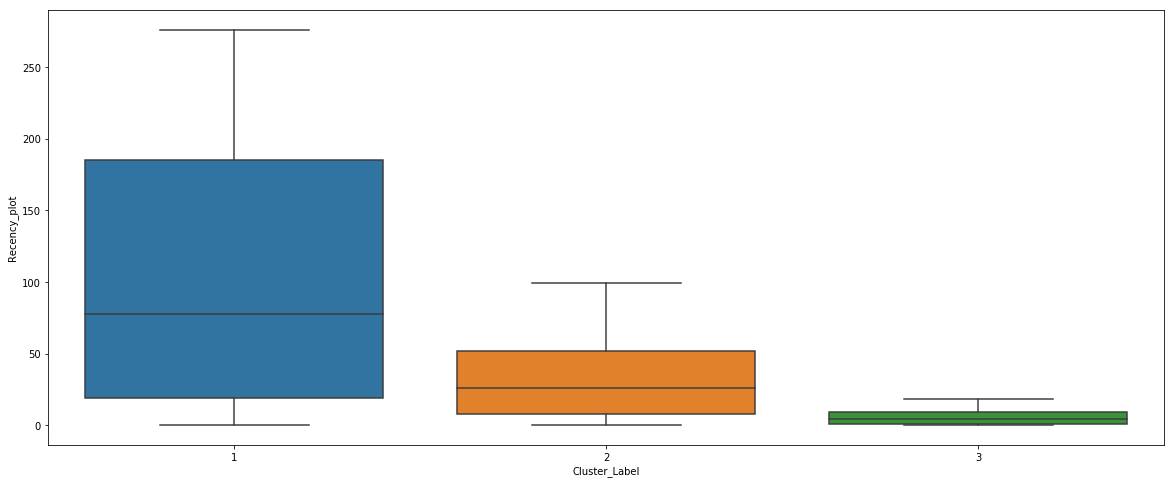

In [302]:
map_and_setup_boxplots("Recency")

As we can see, there is clearly some variation in Recency between customers in Cluster 2, whereas the **spread** within Cluster 3 is very minimal.

### Frequency

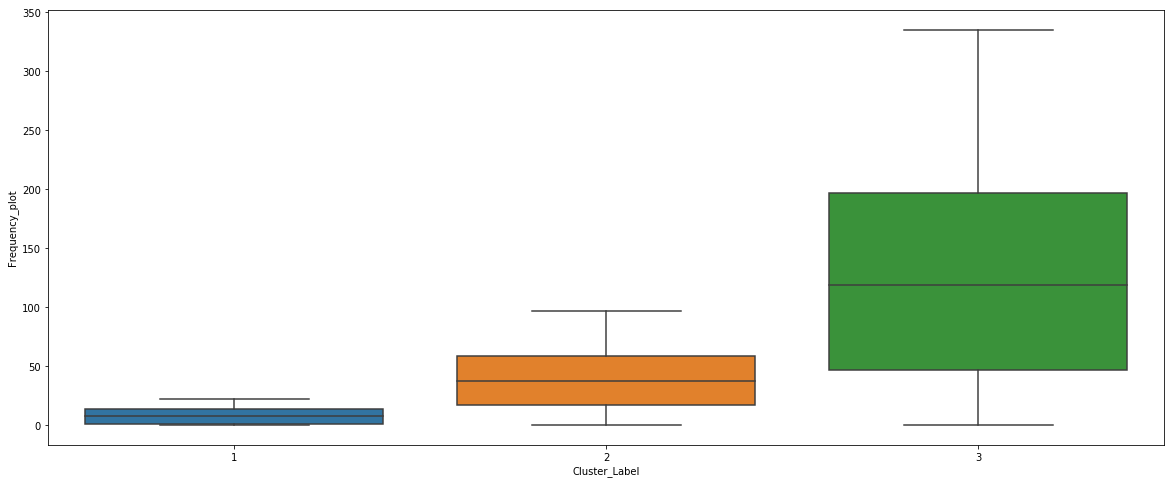

In [303]:
map_and_setup_boxplots("Frequency")

The **median** Frequency value for customers in Cluster 3 is clearly **higher** than those in the other clusters, whereas Cluster 2 consists of customers with a **small range** of frequencies. Cluster 1 members have a slightly larger spread in values than Cluster 2, but clearly less than those in cluster 3.

### Monetary Value

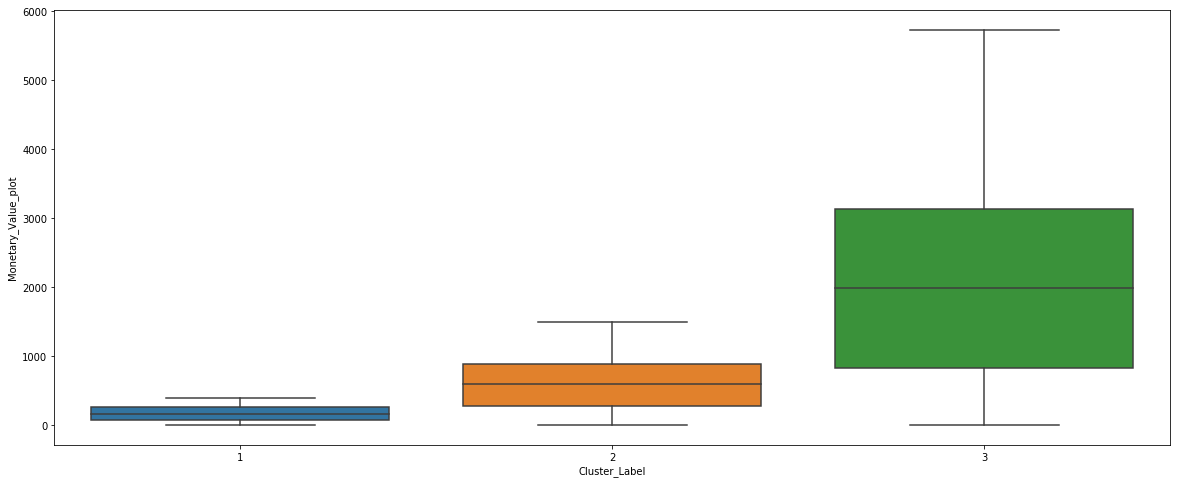

In [304]:
map_and_setup_boxplots("Monetary_Value")

As discussed above, **Cluster 3** members have the largest monetary value to the retail store, and the group as a whole also carries a **larger Median value** than the other two.

# <div id="sec 4">Section 4: Conclusion </div>


## <div id="4.1">4.1:  Evaluating the results</div>


Let's reflect on our work in this project once more.

After a long **Exploratory Data Analysis** section, we generated three key metrics for our individual customers. After doing this, we **Standardized and logarithmically transformed** our Data in order to implement our **KMeans Algorithm** with **3 clusters**.

We also took a 3-dimensional look at our clusters and wrapped up the analysis with some **Boxplots** of the **three customer-value metrics.**

## <div id="4.2">4.2:  Future considerations</div>


A future rerun of this project can:
<ul>
  <li>Utilize <a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html">Silhouette Analysis</a> to select the optimal number of clusters for KMeans Algorithm</li>
  <li>Implement <a href="https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/">Hierarchical Clustering</a> instead as our Unsupervised Model of choice</li>
  <li>Carry out Market Basket Analysis to find the possible items to recommend to customers based on their purchases</li>
</ul>



## CITATION

-This dataset was obtained from the <a href="https://archive.ics.uci.edu/ml/datasets/online+retail"> UCI Machine Learning Repository</a> thanks to the hard work of :

$$Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197â€“208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17).$$